In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



In [81]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

spy = spy.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [82]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)


In [83]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

tlt = tlt.iloc[:, :-1]  # Select all rows and all columns except the last one

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)


In [84]:
def generate_signals(df):
    """Generate trading signals based on SMA crossovers confirmed by MACD"""
    signals = pd.DataFrame(index=df.index)
    signals['price'] = df['Close']

    # === SMA Crossovers ===
    signals['sma5_10'] = np.where(df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close'], 1, -1)
    signals['sma10_15'] = np.where(df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'], 1, -1)

    # Require both crossovers to align for a signal
    signals['signal'] = 0
    signals.loc[(signals['sma5_10'] == 1) & (signals['sma10_15'] == 1), 'signal'] = 2
    signals.loc[(signals['sma5_10'] == -1) & (signals['sma10_15'] == -1), 'signal'] = -2

    # === MACD Confirmation ===
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    macd_diff = macd - macd_signal

    signals['macd'] = macd
    signals['macd_signal'] = macd_signal
    signals['macd_diff'] = macd_diff

    # Final signal only if MACD confirms
    signals['confirmed_signal'] = 0
    signals.loc[(signals['signal'] == 2) & (signals['macd_diff'] > 0), 'confirmed_signal'] = 2
    signals.loc[(signals['signal'] == -2) & (signals['macd_diff'] < 0), 'confirmed_signal'] = -2

    # used later for bitcoin off-hour trading & generation of signals
    signals['momentum'] = df['Close'].pct_change(5)

    return signals


#An SMA crossover occurs when one SMA crosses above or below another SMA.
# For example:
# If SMAVG (5) > SMAVG (10), it indicates a short-term bullish trend → Signal = 1.
# If SMAVG (5) ≤ SMAVG (10), it indicates a short-term bearish trend → Signal = -1.
# Similarly:
# If SMAVG (10) > SMAVG (15), it indicates a medium-term bullish trend → Signal = 1.
# If SMAVG (10) ≤ SMAVG (15), it indicates a medium-term bearish trend → Signal = -1.

#The two SMA signals are combined into a single signal:
# Possible values for 'signal':
# +2: Strong bullish trend (sma5_10 = 1 and sma10_15 = 1).
# +1: Mild bullish trend (one SMA signal is bullish, the other is neutral or bearish).
# 0: Neutral trend (the two SMA signals cancel each other out).
# -1: Mild bearish trend.
# -2: Strong bearish trend (sma5_10 = -1 and sma10_15 = -1).

# This is better than a simple trend-following strategy because this is more suited for asset rebalancing
# we are not just deciding whether to be in or out (binary result), we're deciding how much to allocate based on conviction.



In [86]:
def handle_btc_off_hours(btc_signal, current_allocation, current_time, last_btc_adjustment_time, cooldown_hours=4):
    new_allocation = current_allocation.copy()
    signal = btc_signal['confirmed_signal'].iloc[-1]
    momentum = btc_signal['momentum'].iloc[-1]

    current_btc = new_allocation['BTC']
    current_cash = new_allocation['CASH']

    # Check time condition to avoid overtrading
    if last_btc_adjustment_time is not None:
        hours_since_last = (current_time - last_btc_adjustment_time).total_seconds() / 3600
        if hours_since_last < cooldown_hours:
            return current_allocation, last_btc_adjustment_time

    # Define BTC bounds and dynamic step
    btc_min = 0.05
    btc_max = 0.20
    base_step = 0.05
    dynamic_step = min(base_step + abs(momentum) * 2, 0.10)

    if signal > 0 and momentum > 0:
        new_btc = min(current_btc + dynamic_step, btc_max)
        delta = new_btc - current_btc
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = max(0.01, current_cash - delta)
        return new_allocation, current_time

    elif signal < 0 and momentum < 0:
        new_btc = max(current_btc - dynamic_step, btc_min)
        delta = current_btc - new_btc
        new_allocation['BTC'] = new_btc
        new_allocation['CASH'] = min(1.0, current_cash + delta)
        return new_allocation, current_time

    return new_allocation, last_btc_adjustment_time





In [87]:
# triggers portfolio rebalancing only if drift exceeds the defined threshold, so that we dont rebalance portfolio with every tiny change, saves on transaction costs 
def allocation_drift_exceeds(current, target, threshold): 
    """
    Check if allocation drift exceeds threshold for any asset.
    """
    return any(abs(current[asset] - target[asset]) > threshold for asset in current)


In [89]:
def determine_allocation(btc_signal, spy_signal, tlt_signal, current_allocation):
    """
    Determine target allocation based on multi-asset signals.
    Incorporates momentum, volatility, and risk constraints.
    """
    new_allocation = current_allocation.copy()
    
    # === CONFIGURABLE PARAMETERS ===
    asset_params = {
        'SPY': {'max': 0.80, 'min': 0.10, 'step': 0.05, 'signal': spy_signal},
        'BTC': {'max': 0.20, 'min': 0.10, 'step': 0.05, 'signal': btc_signal},
        'TLT': {'max': 0.05, 'min': 0.00, 'step': 0.05, 'signal': tlt_signal},
    }

    # === ASSET-BY-ASSET ADJUSTMENT ===
    for asset, params in asset_params.items():
        sig = params['signal']['confirmed_signal'].iloc[-1]
        momentum = params['signal']['momentum'].iloc[-1]
        step = min(params['step'] + abs(momentum) * 2, 0.10)  # adaptive step

        if sig == 2 and momentum > 0:
            # Bullish → increase
            target = min(new_allocation[asset] + step, params['max'])
            delta = target - new_allocation[asset]
            if new_allocation['CASH'] >= delta:
                new_allocation[asset] = target
                new_allocation['CASH'] = max(0.01, new_allocation['CASH'] - delta)

        elif sig == -2 and momentum < 0:
            # Bearish → reduce
            target = max(new_allocation[asset] - step, params['min'])
            delta = new_allocation[asset] - target
            new_allocation[asset] = target
            new_allocation['CASH'] = min(1.0, new_allocation['CASH'] + delta)

    # === BEARISH MARKET CONDITION → DE-RISK ===
    if all(sig['confirmed_signal'].iloc[-1] < 0 for sig in [btc_signal, spy_signal, tlt_signal]):
        new_allocation['CASH'] = max(new_allocation['CASH'], 0.40)
        total_risk = new_allocation['BTC'] + new_allocation['SPY'] + new_allocation['TLT']
        if total_risk > 0:
            factor = (1.0 - new_allocation['CASH']) / total_risk
            for asset in ['BTC', 'SPY', 'TLT']:
                new_allocation[asset] *= factor

    # === NORMALIZE (Prevent rounding issues) ===
    total = sum(new_allocation.values())
    for asset in new_allocation:
        new_allocation[asset] = max(0.0, new_allocation[asset] / total)

    return new_allocation



In [91]:
def rebalance_portfolio(current_allocation, target_allocation, total_portfolio_value,
                        current_holdings, latest_prices, entry_prices):
    transaction_costs = {
        'BTC': 0.0005,
        'SPY': 0.0003,
        'TLT': 0.0003,
        'CASH': 0.0
    }

    new_holdings = {}
    total_cost = 0.0

    target_dollar = {asset: target_allocation[asset] * total_portfolio_value for asset in target_allocation}

    for asset in current_holdings:
        current_val = current_holdings[asset]
        target_val = target_dollar[asset]
        trade_amount = abs(target_val - current_val)
        cost = trade_amount * transaction_costs.get(asset, 0.0)
        total_cost += cost

    net_portfolio_value = total_portfolio_value - total_cost
    target_dollar = {asset: target_allocation[asset] * net_portfolio_value for asset in target_allocation}
    for asset in current_holdings:
        new_holdings[asset] = target_dollar[asset]

    new_total_value = sum(new_holdings.values())
    new_allocation = {asset: new_holdings[asset] / new_total_value for asset in new_holdings}

    new_entry_prices = {}
    for asset in new_holdings:
        if asset == 'CASH':
            new_entry_prices[asset] = None
            continue

        if new_holdings[asset] > 0:
            current_price = latest_prices[asset]
            old_position = current_holdings[asset]
            new_position = new_holdings[asset]

            if old_position == 0:
                new_entry_prices[asset] = current_price
            else:
                old_entry = entry_prices.get(asset)
                if old_entry is None:
                    old_entry = current_price
                blended_price = (old_entry * old_position + current_price * (new_position - old_position)) / new_position
                new_entry_prices[asset] = blended_price
        else:
            new_entry_prices[asset] = None

    return new_allocation, new_holdings, new_entry_prices


In [97]:
def updated_backtest_strategy(start_date, end_date, btc_data, spy_data, tlt_data,
                              initial_capital=1000000,
                              rebalance_threshold=0.05):
    """Backtest a four-asset strategy (CASH, BTC, SPY, TLT) with signal-based allocation, stop-loss logic, and rebalancing."""

    import numpy as np
    import pandas as pd

    initial_allocation = {
        'CASH': 0.0101,
        'BTC': 0.1192,
        'SPY': 0.8707,
        'TLT': 0.0000
    }

    current_allocation = initial_allocation.copy()
    current_holdings = {asset: initial_capital * weight for asset, weight in current_allocation.items()}

    # === Set initial entry prices based on first available prices on or after start_date ===
    initial_prices = {
        'BTC': btc_data[btc_data['Date'] >= pd.to_datetime(start_date)]['Close'].iloc[0],
        'SPY': spy_data[spy_data['Date'] >= pd.to_datetime(start_date)]['Close'].iloc[0],
        'TLT': tlt_data[tlt_data['Date'] >= pd.to_datetime(start_date)]['Close'].iloc[0],
        'CASH': 1.0  # Dummy value for consistency
    }
    entry_prices = {
        asset: initial_prices[asset] if initial_allocation[asset] > 0 else None
        for asset in initial_allocation
    }

    last_btc_adjustment_time = None
    portfolio_values = []
    allocations_history = []
    returns = []

    dates = pd.date_range(start=start_date, end=end_date, freq='30min')

    for i, date in enumerate(dates):
        is_market_hours = pd.Timestamp(date) in spy_data['Date'].values

        btc_now = btc_data[btc_data['Date'] <= date]
        spy_now = spy_data[spy_data['Date'] <= date]
        tlt_now = tlt_data[tlt_data['Date'] <= date]

        # === Update holdings based on latest price ===
        if len(btc_now) >= 2:
            ret = btc_now['Close'].iloc[-1] / btc_now['Close'].iloc[-2]
            current_holdings['BTC'] *= ret
        if is_market_hours:
            if len(spy_now) >= 2:
                ret = spy_now['Close'].iloc[-1] / spy_now['Close'].iloc[-2]
                current_holdings['SPY'] *= ret
            if len(tlt_now) >= 2:
                ret = tlt_now['Close'].iloc[-1] / tlt_now['Close'].iloc[-2]
                current_holdings['TLT'] *= ret

        portfolio_value = sum(current_holdings.values())
        portfolio_values.append(portfolio_value)
        allocations_history.append(current_allocation.copy())

        if i > 0:
            returns.append((portfolio_value - portfolio_values[i - 1]) / portfolio_values[i - 1])

        # === Stop-loss check ===
        stop_loss_threshold = 0.05
        for asset in ['BTC', 'SPY', 'TLT']:
            if entry_prices[asset] is not None and current_holdings[asset] > 0:
                latest_data = {'BTC': btc_now, 'SPY': spy_now, 'TLT': tlt_now}[asset]
                if not latest_data.empty:
                    latest_price = latest_data['Close'].iloc[-1]
                    if latest_price < entry_prices[asset] * (1 - stop_loss_threshold):
                        print(f"[{date}] Stop-loss triggered on {asset}")
                        cash_from_sale = current_holdings[asset]
                        current_holdings['CASH'] += cash_from_sale
                        current_holdings[asset] = 0
                        current_allocation[asset] = 0
                        entry_prices[asset] = None

        # === Market hours rebalance ===
        if is_market_hours and not btc_now.empty and not spy_now.empty and not tlt_now.empty:
            if btc_now.shape[0] < 15 or spy_now.shape[0] < 15 or tlt_now.shape[0] < 15:
                continue

            btc_signal = generate_signals(btc_now.tail(15))
            spy_signal = generate_signals(spy_now.tail(15))
            tlt_signal = generate_signals(tlt_now.tail(15))

            new_allocation = determine_allocation(btc_signal, spy_signal, tlt_signal, current_allocation)

            if allocation_drift_exceeds(current_allocation, new_allocation, rebalance_threshold):
                latest_prices = {
                    'BTC': btc_now['Close'].iloc[-1],
                    'SPY': spy_now['Close'].iloc[-1],
                    'TLT': tlt_now['Close'].iloc[-1],
                    'CASH': 1.0
                }
                current_allocation, current_holdings, new_entry_prices = rebalance_portfolio(
                    current_allocation, new_allocation, portfolio_value, current_holdings, latest_prices, entry_prices
                )
                for asset, entry_price in new_entry_prices.items():
                    if entry_price is not None:
                        entry_prices[asset] = entry_price

        # === BTC off-hour rebalance ===
        elif not is_market_hours and not btc_now.empty:
            if btc_now.shape[0] < 15:
                continue

            btc_signal = generate_signals(btc_now.tail(15))
            new_allocation, last_btc_adjustment_time = handle_btc_off_hours(
                btc_signal, current_allocation, date, last_btc_adjustment_time
            )

            if allocation_drift_exceeds(current_allocation, new_allocation, rebalance_threshold):
                latest_prices = {'BTC': btc_now['Close'].iloc[-1], 'SPY': 0.0, 'TLT': 0.0, 'CASH': 1.0}
                current_allocation, current_holdings, new_entry_prices = rebalance_portfolio(
                    current_allocation, new_allocation, portfolio_value, current_holdings, latest_prices, entry_prices
                )
                for asset, entry_price in new_entry_prices.items():
                    if entry_price is not None:
                        entry_prices[asset] = entry_price

    portfolio_series = pd.Series(portfolio_values, index=dates)

    # === Compute performance metrics ===
    returns_series = pd.Series(returns)
    sharpe_ratio = (returns_series.mean() / returns_series.std()) * np.sqrt(252 * 13)
    running_max = portfolio_series.cummax()
    drawdown = (portfolio_series - running_max) / running_max
    max_drawdown = drawdown.min()

    print(f"\nFinal Portfolio Value: ${portfolio_series.iloc[-1]:,.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    return portfolio_series, pd.DataFrame(allocations_history, index=dates)



In [99]:
start_date = "2025-01-01"
end_date = "2025-02-28"

portfolio_values, allocations_history = updated_backtest_strategy(
    start_date=start_date,
    end_date=end_date,
    btc_data=btc,
    spy_data=spy,
    tlt_data=tlt,
    initial_capital=1000000,
    rebalance_threshold=0.1
)


[2025-02-25 15:00:00] Stop-loss triggered on BTC

Final Portfolio Value: $1,000,847.81
Sharpe Ratio: 0.1178
Max Drawdown: -4.45%


In [100]:
portfolio_values

2025-01-01 00:00:00    9.967137e+05
2025-01-01 00:30:00    9.967861e+05
2025-01-01 01:00:00    9.945996e+05
2025-01-01 01:30:00    9.960920e+05
2025-01-01 02:00:00    9.926146e+05
                           ...     
2025-02-27 22:00:00    1.003275e+06
2025-02-27 22:30:00    9.996258e+05
2025-02-27 23:00:00    1.002681e+06
2025-02-27 23:30:00    1.001108e+06
2025-02-28 00:00:00    1.000848e+06
Freq: 30min, Length: 2785, dtype: float64

In [101]:
def plot_portfolio_performance(portfolio_values):
    """Visualize how the portfolio performed over time"""
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.title('Portfolio Performance (Jan–Feb 2025)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


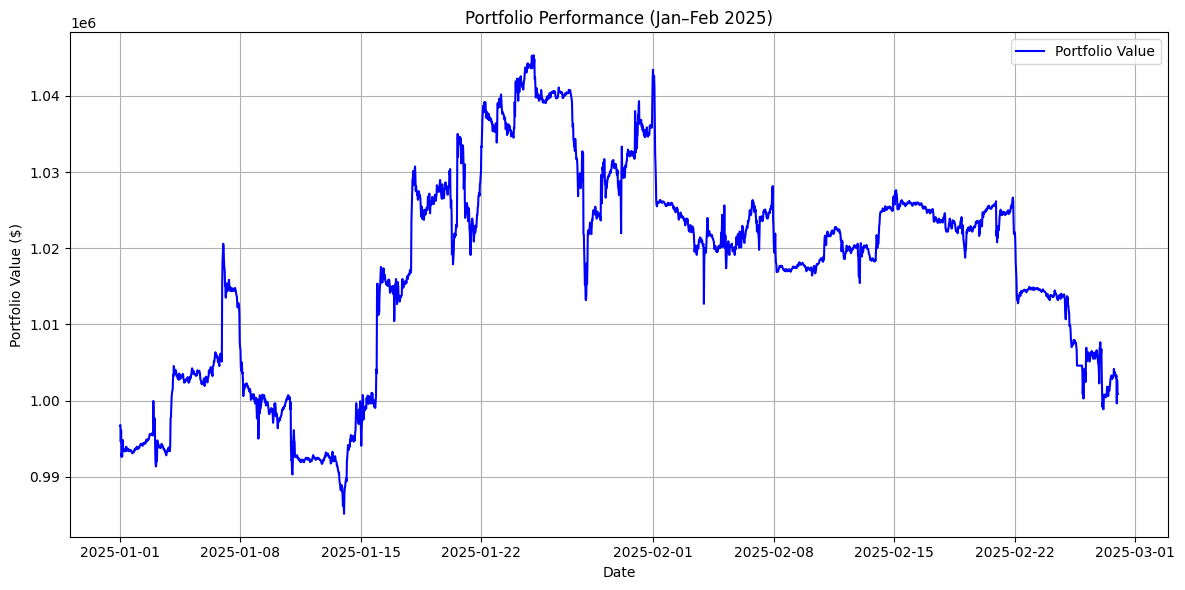

In [102]:
plot_portfolio_performance(portfolio_values)
